<a href="https://colab.research.google.com/github/AnkitaDasData/AnalyticsHub/blob/main/Projects/Customer_Churn_Analysis_PySpark.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### **Task 1 - Loading our data**

Installing the pyspark using pip

In [1]:
!pip install pyspark

Importing Modules

In [2]:
# importing spark session
from pyspark.sql import SparkSession

# data visualization modules
import matplotlib.pyplot as plt
import plotly.express as px

# pandas module
import pandas as pd

# pyspark SQL functions
from pyspark.sql.functions import col, when, count, udf

# pyspark data preprocessing modules
from pyspark.ml.feature import Imputer, StringIndexer, VectorAssembler, StandardScaler, OneHotEncoder

# pyspark data modeling and model evaluation modules
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator


Building our Spark Session

In [3]:
spark = SparkSession.builder.appName("Customer_Churn_Prediction").getOrCreate()
spark

Loading our data

In [4]:
#MOUNTING FOLDER/LOCATION for files
# loading data
import os
from google.colab import drive

# Define the mount point and your directory path
mount_path = '/content/drive/MyDrive/AnalyticsHub/Projects/Exploring_PySpark'

# Unmount the drive first to avoid issues
if os.path.exists('/content/drive'):
    try:
        drive.flush_and_unmount()
        print("Successfully unmounted the drive.")
    except:
        print("Drive not mounted, skipping unmount step.")

# Now, remove any existing files from the mount point if needed
if os.path.exists('/content/drive'):
    try:
        os.system('rm -rf /content/drive')
        print("Cleared the existing mount point.")
    except Exception as e:
        print(f"Error clearing mount point: {e}")

# Remount Google Drive
try:
    drive.mount('/content/drive', force_remount=True)  # Mount the drive
    print("Google Drive mounted successfully.")

    # Create the target directory if it doesn't exist
    if not os.path.exists(mount_path):
        os.makedirs(mount_path)
        print(f"Created directory: {mount_path}")
except ValueError as e:
    print(f"Failed to mount Google Drive: {e}")


Successfully unmounted the drive.
Mounted at /content/drive
Google Drive mounted successfully.


In [5]:
# IMPRORTING DATA
data_path = '/content/drive/MyDrive/AnalyticsHub/Projects/Exploring_PySpark/dataset.csv'

# Check if file exists
if not os.path.exists(data_path):
    raise FileNotFoundError(f"File not found: {data_path}")

# Load the data
data = spark.read\
    .format('csv') \
    .option('inferSchema', True)\
    .option('header', True)\
    .load(data_path)

In [6]:
# EXPLORING DATA
data.show()

+----------+------+-------------+-------+----------+------+------------+----------------+---------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+--------------+----------------+--------------------+--------------+------------+-----+
|customerID|gender|SeniorCitizen|Partner|Dependents|tenure|PhoneService|   MultipleLines|InternetService|     OnlineSecurity|       OnlineBackup|   DeviceProtection|        TechSupport|        StreamingTV|    StreamingMovies|      Contract|PaperlessBilling|       PaymentMethod|MonthlyCharges|TotalCharges|Churn|
+----------+------+-------------+-------+----------+------+------------+----------------+---------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+--------------+----------------+--------------------+--------------+------------+-----+
|7590-VHVEG|Female|           No|    Yes|        No|     1|  

Print the data schema to check out the data types

In [7]:
data.printSchema()

root
 |-- customerID: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- SeniorCitizen: string (nullable = true)
 |-- Partner: string (nullable = true)
 |-- Dependents: string (nullable = true)
 |-- tenure: integer (nullable = true)
 |-- PhoneService: string (nullable = true)
 |-- MultipleLines: string (nullable = true)
 |-- InternetService: string (nullable = true)
 |-- OnlineSecurity: string (nullable = true)
 |-- OnlineBackup: string (nullable = true)
 |-- DeviceProtection: string (nullable = true)
 |-- TechSupport: string (nullable = true)
 |-- StreamingTV: string (nullable = true)
 |-- StreamingMovies: string (nullable = true)
 |-- Contract: string (nullable = true)
 |-- PaperlessBilling: string (nullable = true)
 |-- PaymentMethod: string (nullable = true)
 |-- MonthlyCharges: double (nullable = true)
 |-- TotalCharges: double (nullable = true)
 |-- Churn: string (nullable = true)



Get the data dimension

In [8]:
data.count()

7043

In [9]:
data.columns

['customerID',
 'gender',
 'SeniorCitizen',
 'Partner',
 'Dependents',
 'tenure',
 'PhoneService',
 'MultipleLines',
 'InternetService',
 'OnlineSecurity',
 'OnlineBackup',
 'DeviceProtection',
 'TechSupport',
 'StreamingTV',
 'StreamingMovies',
 'Contract',
 'PaperlessBilling',
 'PaymentMethod',
 'MonthlyCharges',
 'TotalCharges',
 'Churn']

In [10]:
len(data.columns)

21

### **Task 2 - Exploratory Data Analysis**
- Distribution Analysis
- Correlation Analysis
- Univariate Analysis
- Finding Missing values

Let's define some lists to store different column names with different data types.

In [11]:
data.show(5)

+----------+------+-------------+-------+----------+------+------------+----------------+---------------+--------------+------------+----------------+-----------+-----------+---------------+--------------+----------------+--------------------+--------------+------------+-----+
|customerID|gender|SeniorCitizen|Partner|Dependents|tenure|PhoneService|   MultipleLines|InternetService|OnlineSecurity|OnlineBackup|DeviceProtection|TechSupport|StreamingTV|StreamingMovies|      Contract|PaperlessBilling|       PaymentMethod|MonthlyCharges|TotalCharges|Churn|
+----------+------+-------------+-------+----------+------+------------+----------------+---------------+--------------+------------+----------------+-----------+-----------+---------------+--------------+----------------+--------------------+--------------+------------+-----+
|7590-VHVEG|Female|           No|    Yes|        No|     1|          No|No phone service|            DSL|            No|         Yes|              No|         No|    

In [12]:
data.dtypes

[('customerID', 'string'),
 ('gender', 'string'),
 ('SeniorCitizen', 'string'),
 ('Partner', 'string'),
 ('Dependents', 'string'),
 ('tenure', 'int'),
 ('PhoneService', 'string'),
 ('MultipleLines', 'string'),
 ('InternetService', 'string'),
 ('OnlineSecurity', 'string'),
 ('OnlineBackup', 'string'),
 ('DeviceProtection', 'string'),
 ('TechSupport', 'string'),
 ('StreamingTV', 'string'),
 ('StreamingMovies', 'string'),
 ('Contract', 'string'),
 ('PaperlessBilling', 'string'),
 ('PaymentMethod', 'string'),
 ('MonthlyCharges', 'double'),
 ('TotalCharges', 'double'),
 ('Churn', 'string')]

In [13]:
num_columns = [ name for name, typ in data.dtypes if typ =='double' or typ =='int']
num_columns

['tenure', 'MonthlyCharges', 'TotalCharges']

In [14]:
cat_columns = [ name for name, typ in data.dtypes if typ =='string']
cat_columns

['customerID',
 'gender',
 'SeniorCitizen',
 'Partner',
 'Dependents',
 'PhoneService',
 'MultipleLines',
 'InternetService',
 'OnlineSecurity',
 'OnlineBackup',
 'DeviceProtection',
 'TechSupport',
 'StreamingTV',
 'StreamingMovies',
 'Contract',
 'PaperlessBilling',
 'PaymentMethod',
 'Churn']

In [15]:
data.select(num_columns).show()

+------+--------------+------------+
|tenure|MonthlyCharges|TotalCharges|
+------+--------------+------------+
|     1|         29.85|       29.85|
|    34|         56.95|      1889.5|
|     2|         53.85|      108.15|
|    45|          42.3|     1840.75|
|     2|          70.7|      151.65|
|     8|         99.65|       820.5|
|    22|          89.1|      1949.4|
|    10|         29.75|       301.9|
|    28|         104.8|     3046.05|
|    62|         56.15|     3487.95|
|    13|         49.95|      587.45|
|    16|         18.95|       326.8|
|    58|        100.35|      5681.1|
|    49|         103.7|      5036.3|
|    25|         105.5|     2686.05|
|    69|        113.25|     7895.15|
|    52|         20.65|     1022.95|
|    71|         106.7|     7382.25|
|    10|          55.2|      528.35|
|    21|         90.05|      1862.9|
+------+--------------+------------+
only showing top 20 rows



Let's get all the numerical features and store them into a pandas dataframe.

In [16]:
df = data.select(num_columns).toPandas()
df.head()

,tenure,MonthlyCharges,TotalCharges
0,1,29.85,29.85
1,34,56.95,1889.50
2,2,53.85,108.15
3,45,42.30,1840.75
4,2,70.70,151.65


Let's create histograms to analyse the distribution of our numerical columns.

<ipython-input-17-bddc9440312d>:3: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  df.hist(ax=ax, bins = 20)


array([[<Axes: title={'center': 'tenure'}>,
        <Axes: title={'center': 'MonthlyCharges'}>],
       [<Axes: title={'center': 'TotalCharges'}>, <Axes: >]], dtype=object)

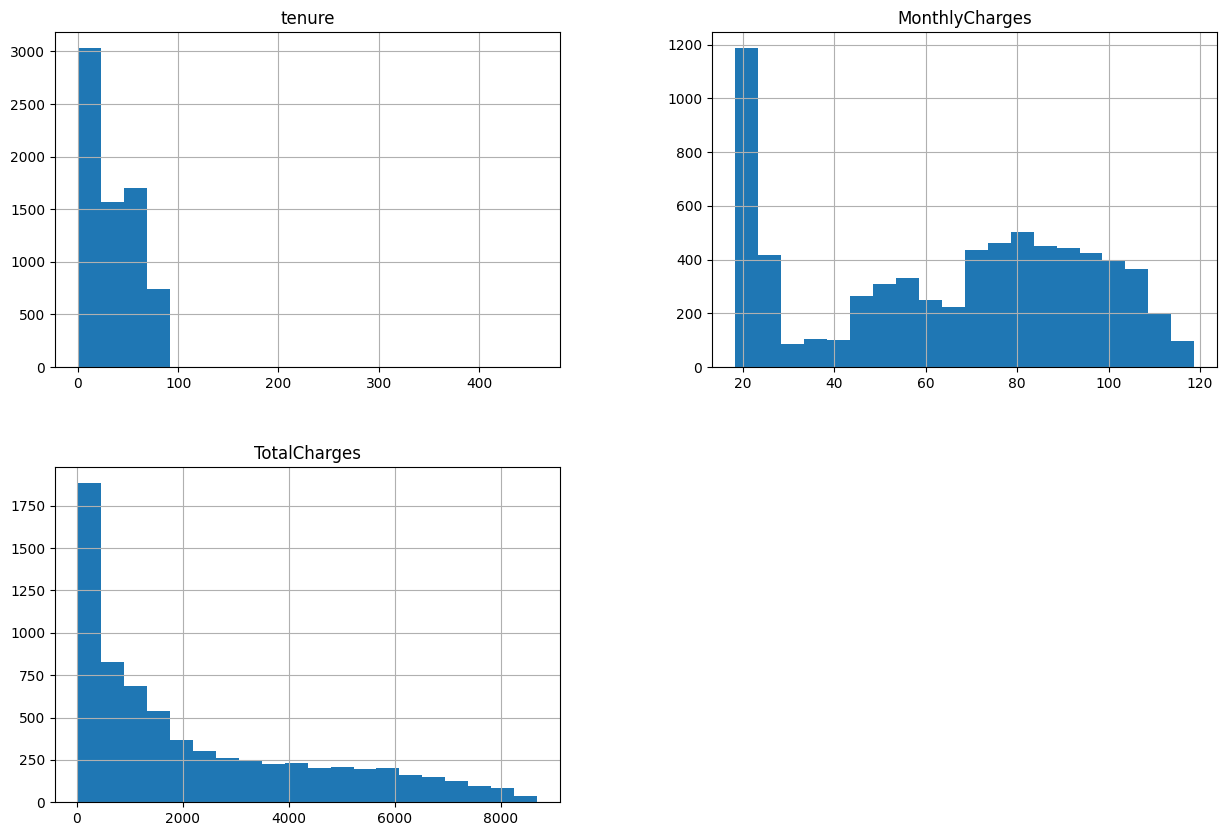

In [17]:
fig = plt.figure(figsize=(15,10))
ax = fig.gca()
df.hist(ax=ax, bins = 20)

In [18]:
df.tenure.describe()

,tenure
count,7043.000000
mean,32.435752
std,25.075228
min,0.000000
25%,9.000000
50%,29.000000
75%,55.000000
max,458.000000


Let's generate the correlation matrix

In [19]:
df.corr()

,tenure,MonthlyCharges,TotalCharges
tenure,1.000000,0.243703,0.806530
MonthlyCharges,0.243703,1.000000,0.651065
TotalCharges,0.806530,0.651065,1.000000


Let's check the unique value count per each categorical variables

In [20]:
data.select("Contract").show()

+--------------+
|      Contract|
+--------------+
|Month-to-month|
|      One year|
|Month-to-month|
|      One year|
|Month-to-month|
|Month-to-month|
|Month-to-month|
|Month-to-month|
|Month-to-month|
|      One year|
|Month-to-month|
|      Two year|
|      One year|
|Month-to-month|
|Month-to-month|
|      Two year|
|      One year|
|      Two year|
|Month-to-month|
|Month-to-month|
+--------------+
only showing top 20 rows



In [21]:
data.groupby("Contract").count().show()

+--------------+-----+
|      Contract|count|
+--------------+-----+
|Month-to-month| 3875|
|      One year| 1473|
|      Two year| 1695|
+--------------+-----+



In [22]:
for column in cat_columns:
  data.groupby(column).count().show()

+----------+-----+
|customerID|count|
+----------+-----+
|3668-QPYBK|    1|
|6234-RAAPL|    1|
|1894-IGFSG|    1|
|6982-SSHFK|    1|
|5859-HZYLF|    1|
|6479-OAUSD|    1|
|2592-YKDIF|    1|
|6718-BDGHG|    1|
|3195-TQDZX|    1|
|4248-QPAVC|    1|
|5668-MEISB|    1|
|5802-ADBRC|    1|
|2712-SYWAY|    1|
|2011-TRQYE|    1|
|7244-KXYZN|    1|
|0953-LGOVU|    1|
|3623-FQBOX|    1|
|3692-JHONH|    1|
|3528-HFRIQ|    1|
|7661-CPURM|    1|
+----------+-----+
only showing top 20 rows

+------+-----+
|gender|count|
+------+-----+
|Female| 3488|
|  Male| 3555|
+------+-----+

+-------------+-----+
|SeniorCitizen|count|
+-------------+-----+
|           No| 5901|
|          Yes| 1142|
+-------------+-----+

+-------+-----+
|Partner|count|
+-------+-----+
|     No| 3641|
|    Yes| 3402|
+-------+-----+

+----------+-----+
|Dependents|count|
+----------+-----+
|        No| 4933|
|       Yes| 2110|
+----------+-----+

+------------+-----+
|PhoneService|count|
+------------+-----+
|          No|  682

In [23]:
data.select("Churn").show()

+-----+
|Churn|
+-----+
|   No|
|   No|
|  Yes|
|   No|
|  Yes|
|  Yes|
|   No|
|   No|
|  Yes|
|   No|
|   No|
|   No|
|   No|
|  Yes|
|   No|
|   No|
|   No|
|   No|
|  Yes|
|   No|
+-----+
only showing top 20 rows



In [24]:
data.select(count("Churn").alias("C")).show()  # counts non-null values

+----+
|   C|
+----+
|7043|
+----+



In [25]:
# Or
data.filter(data.Churn.isNotNull()).count()

7043

Let's find number of null values in all of our dataframe columns

In [26]:
data.filter(data.Churn.isNull()).show()
#count() returns the number of rows as an integer
#show() displays the DataFrame content

+----------+------+-------------+-------+----------+------+------------+-------------+---------------+--------------+------------+----------------+-----------+-----------+---------------+--------+----------------+-------------+--------------+------------+-----+
|customerID|gender|SeniorCitizen|Partner|Dependents|tenure|PhoneService|MultipleLines|InternetService|OnlineSecurity|OnlineBackup|DeviceProtection|TechSupport|StreamingTV|StreamingMovies|Contract|PaperlessBilling|PaymentMethod|MonthlyCharges|TotalCharges|Churn|
+----------+------+-------------+-------+----------+------+------------+-------------+---------------+--------------+------------+----------------+-----------+-----------+---------------+--------+----------------+-------------+--------------+------------+-----+
+----------+------+-------------+-------+----------+------+------------+-------------+---------------+--------------+------------+----------------+-----------+-----------+---------------+--------+----------------+-

In [27]:
# Or
data.filter(data["Churn"].isNull()).count()

0

In [28]:
for column in data.columns:
  print(column, data.filter(data[column].isNull()).count())

customerID 0
gender 0
SeniorCitizen 0
Partner 0
Dependents 0
tenure 0
PhoneService 0
MultipleLines 0
InternetService 0
OnlineSecurity 0
OnlineBackup 0
DeviceProtection 0
TechSupport 0
StreamingTV 0
StreamingMovies 0
Contract 0
PaperlessBilling 0
PaymentMethod 0
MonthlyCharges 0
TotalCharges 11
Churn 0


In [29]:
# Method 1: Using SQL expressions
for column in data.columns:
    data.selectExpr(f"count(case when {column} is null then 1 end) as {column}_nulls").show()


+----------------+
|customerID_nulls|
+----------------+
|               0|
+----------------+

+------------+
|gender_nulls|
+------------+
|           0|
+------------+

+-------------------+
|SeniorCitizen_nulls|
+-------------------+
|                  0|
+-------------------+

+-------------+
|Partner_nulls|
+-------------+
|            0|
+-------------+

+----------------+
|Dependents_nulls|
+----------------+
|               0|
+----------------+

+------------+
|tenure_nulls|
+------------+
|           0|
+------------+

+------------------+
|PhoneService_nulls|
+------------------+
|                 0|
+------------------+

+-------------------+
|MultipleLines_nulls|
+-------------------+
|                  0|
+-------------------+

+---------------------+
|InternetService_nulls|
+---------------------+
|                    0|
+---------------------+

+--------------------+
|OnlineSecurity_nulls|
+--------------------+
|                   0|
+--------------------+

+---------

In [30]:
# Or Method 2: Using PySpark functions
for column in data.columns:
    data.select(count(when(data[column].isNull(), 1)).alias(f"{column}_nulls")).show()

+----------------+
|customerID_nulls|
+----------------+
|               0|
+----------------+

+------------+
|gender_nulls|
+------------+
|           0|
+------------+

+-------------------+
|SeniorCitizen_nulls|
+-------------------+
|                  0|
+-------------------+

+-------------+
|Partner_nulls|
+-------------+
|            0|
+-------------+

+----------------+
|Dependents_nulls|
+----------------+
|               0|
+----------------+

+------------+
|tenure_nulls|
+------------+
|           0|
+------------+

+------------------+
|PhoneService_nulls|
+------------------+
|                 0|
+------------------+

+-------------------+
|MultipleLines_nulls|
+-------------------+
|                  0|
+-------------------+

+---------------------+
|InternetService_nulls|
+---------------------+
|                    0|
+---------------------+

+--------------------+
|OnlineSecurity_nulls|
+--------------------+
|                   0|
+--------------------+

+---------

Let's drop the outlier row

### **Task 3 - Data Preprocessing**
- Handling the missing values
- Removing the outliers

**Handling the missing values** <br>
Let's create a list of column names with missing values

In [31]:
# column to handle
columns_with_missing_values = ["TotalCharges"]

Creating our Imputer

In [32]:
# using imputer
imputer = Imputer(
    inputCols=columns_with_missing_values,
    outputCols=["{}_imputed".format(c) for c in columns_with_missing_values]
).setStrategy("mean")

Use Imputer to fill the missing values

In [33]:
imputer = imputer.fit(data)

In [34]:
data = imputer.transform(data)

Let's check the missing value counts again

In [35]:
data.select(count(when(col("TotalCharges").isNull(),"TotalCharges")).alias("TotalCharges")).show()

+------------+
|TotalCharges|
+------------+
|          11|
+------------+



In [36]:
data.select(count(when(col("TotalCharges_imputed").isNull(),"TotalCharges"))).show()

+---------------------------------------------------------------------+
|count(CASE WHEN (TotalCharges_imputed IS NULL) THEN TotalCharges END)|
+---------------------------------------------------------------------+
|                                                                    0|
+---------------------------------------------------------------------+



**Removing the outliers** <br>
Let's find the customer with the tenure higher than 100

In [37]:
data.select("*").where(data.tenure > 100).show()

+----------+------+-------------+-------+----------+------+------------+-------------+---------------+--------------+------------+----------------+-----------+-----------+---------------+--------------+----------------+----------------+--------------+------------+-----+--------------------+
|customerID|gender|SeniorCitizen|Partner|Dependents|tenure|PhoneService|MultipleLines|InternetService|OnlineSecurity|OnlineBackup|DeviceProtection|TechSupport|StreamingTV|StreamingMovies|      Contract|PaperlessBilling|   PaymentMethod|MonthlyCharges|TotalCharges|Churn|TotalCharges_imputed|
+----------+------+-------------+-------+----------+------+------------+-------------+---------------+--------------+------------+----------------+-----------+-----------+---------------+--------------+----------------+----------------+--------------+------------+-----+--------------------+
|5122-CYFXA|Female|           No|     No|        No|   458|         Yes|           No|            DSL|            No|       

In [38]:
print("Before removal of outlier", data.count())
data = data.filter(data.tenure < 100)
print("After removal of outlier", data.count())

Before removal of outlier 7043
After removal of outlier 7042


### **Task 4 - Feature Preparation**
- Numerical Features
    - Vector Assembling
    - Numerical Scaling
- Categorical Features
    - String Indexing
    - Vector Assembling

- Combining the numerical and categorical feature vectors




**Feature Preparation - Numerical Features** <br>

`Vector Assembling --> Standard Scaling` <br>

**Vector Assembling** <br>
To apply our machine learning model we need to combine all of our numerical and categorical features into vectors. For now let's create a feature vector for our numerical columns.


In [39]:
numerical_vector_assembler = VectorAssembler(inputCols = num_columns,
                                             outputCol = "numerical_features",
                                             handleInvalid="skip") #for future scenarios where nulls are present in some rows for some of the columns combined in numerical_features.
data = numerical_vector_assembler.transform(data)
data.show()

+----------+------+-------------+-------+----------+------+------------+----------------+---------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+--------------+----------------+--------------------+--------------+------------+-----+--------------------+--------------------+
|customerID|gender|SeniorCitizen|Partner|Dependents|tenure|PhoneService|   MultipleLines|InternetService|     OnlineSecurity|       OnlineBackup|   DeviceProtection|        TechSupport|        StreamingTV|    StreamingMovies|      Contract|PaperlessBilling|       PaymentMethod|MonthlyCharges|TotalCharges|Churn|TotalCharges_imputed|  numerical_features|
+----------+------+-------------+-------+----------+------+------------+----------------+---------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+--------------+----------------+--------------------+------------

**Numerical Scaling** <br>
Let's standardize all of our numerical features.

In [40]:
# confirming quality of numerical columns
# Check data types
data.printSchema()

# Check for nulls
for col_name in num_columns:
    print(f"Null count in {col_name}:", data.filter(col(col_name).isNull()).count())

root
 |-- customerID: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- SeniorCitizen: string (nullable = true)
 |-- Partner: string (nullable = true)
 |-- Dependents: string (nullable = true)
 |-- tenure: integer (nullable = true)
 |-- PhoneService: string (nullable = true)
 |-- MultipleLines: string (nullable = true)
 |-- InternetService: string (nullable = true)
 |-- OnlineSecurity: string (nullable = true)
 |-- OnlineBackup: string (nullable = true)
 |-- DeviceProtection: string (nullable = true)
 |-- TechSupport: string (nullable = true)
 |-- StreamingTV: string (nullable = true)
 |-- StreamingMovies: string (nullable = true)
 |-- Contract: string (nullable = true)
 |-- PaperlessBilling: string (nullable = true)
 |-- PaymentMethod: string (nullable = true)
 |-- MonthlyCharges: double (nullable = true)
 |-- TotalCharges: double (nullable = true)
 |-- Churn: string (nullable = true)
 |-- TotalCharges_imputed: double (nullable = true)
 |-- numerical_features: vector

In [41]:
scaler = StandardScaler(inputCol = "numerical_features",
                        outputCol = "scaled_numerical_features",
                        withStd = True,
                        withMean = True)
scaler = scaler.fit(data)
data = scaler.transform(data)
data.show()

+----------+------+-------------+-------+----------+------+------------+----------------+---------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+--------------+----------------+--------------------+--------------+------------+-----+--------------------+--------------------+-------------------------+
|customerID|gender|SeniorCitizen|Partner|Dependents|tenure|PhoneService|   MultipleLines|InternetService|     OnlineSecurity|       OnlineBackup|   DeviceProtection|        TechSupport|        StreamingTV|    StreamingMovies|      Contract|PaperlessBilling|       PaymentMethod|MonthlyCharges|TotalCharges|Churn|TotalCharges_imputed|  numerical_features|scaled_numerical_features|
+----------+------+-------------+-------+----------+------+------------+----------------+---------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------

**Feature Preperation - Categorical Features** <br>

`String Indexing --> Vector Assembling` <br>

**String Indexing** <br>
We need to convert all the string columns to numeric columns.

In [42]:
cat_columns

['customerID',
 'gender',
 'SeniorCitizen',
 'Partner',
 'Dependents',
 'PhoneService',
 'MultipleLines',
 'InternetService',
 'OnlineSecurity',
 'OnlineBackup',
 'DeviceProtection',
 'TechSupport',
 'StreamingTV',
 'StreamingMovies',
 'Contract',
 'PaperlessBilling',
 'PaymentMethod',
 'Churn']

In [43]:
cat_columns_indexed = [name+ "_Indexed" for name in cat_columns]
cat_columns_indexed

['customerID_Indexed',
 'gender_Indexed',
 'SeniorCitizen_Indexed',
 'Partner_Indexed',
 'Dependents_Indexed',
 'PhoneService_Indexed',
 'MultipleLines_Indexed',
 'InternetService_Indexed',
 'OnlineSecurity_Indexed',
 'OnlineBackup_Indexed',
 'DeviceProtection_Indexed',
 'TechSupport_Indexed',
 'StreamingTV_Indexed',
 'StreamingMovies_Indexed',
 'Contract_Indexed',
 'PaperlessBilling_Indexed',
 'PaymentMethod_Indexed',
 'Churn_Indexed']

In [44]:
indexer = StringIndexer(inputCols = cat_columns,
                        outputCols = cat_columns_indexed,
                        handleInvalid="skip")
indexer = indexer.fit(data)
data = indexer.transform(data)
data.show()

+----------+------+-------------+-------+----------+------+------------+----------------+---------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+--------------+----------------+--------------------+--------------+------------+-----+--------------------+--------------------+-------------------------+------------------+--------------+---------------------+---------------+------------------+--------------------+---------------------+-----------------------+----------------------+--------------------+------------------------+-------------------+-------------------+-----------------------+----------------+------------------------+---------------------+-------------+
|customerID|gender|SeniorCitizen|Partner|Dependents|tenure|PhoneService|   MultipleLines|InternetService|     OnlineSecurity|       OnlineBackup|   DeviceProtection|        TechSupport|        StreamingTV|    StreamingMovies|      Contract|PaperlessB

Let's combine all of our categorifal features in to one feature vector.

In [45]:
cat_columns_indexed.remove("customerID_Indexed")
cat_columns_indexed.remove("Churn_Indexed")

categorical_vector_assembler = VectorAssembler(inputCols = cat_columns_indexed,
                                               outputCol = "categorical_features",
                                               handleInvalid="skip")
data = categorical_vector_assembler.transform(data)
data.show()

+----------+------+-------------+-------+----------+------+------------+----------------+---------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+--------------+----------------+--------------------+--------------+------------+-----+--------------------+--------------------+-------------------------+------------------+--------------+---------------------+---------------+------------------+--------------------+---------------------+-----------------------+----------------------+--------------------+------------------------+-------------------+-------------------+-----------------------+----------------+------------------------+---------------------+-------------+--------------------+
|customerID|gender|SeniorCitizen|Partner|Dependents|tenure|PhoneService|   MultipleLines|InternetService|     OnlineSecurity|       OnlineBackup|   DeviceProtection|        TechSupport|        StreamingTV|    StreamingMovies|    

Now let's combine categorical and numerical feature vectors.

In [46]:
final_feature_vector = VectorAssembler(inputCols = ["scaled_numerical_features", "categorical_features"],
                                       outputCol = "final_feature_vector",
                                       handleInvalid="skip")
data = final_feature_vector.transform(data)
data.show()

+----------+------+-------------+-------+----------+------+------------+----------------+---------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+--------------+----------------+--------------------+--------------+------------+-----+--------------------+--------------------+-------------------------+------------------+--------------+---------------------+---------------+------------------+--------------------+---------------------+-----------------------+----------------------+--------------------+------------------------+-------------------+-------------------+-----------------------+----------------+------------------------+---------------------+-------------+--------------------+--------------------+
|customerID|gender|SeniorCitizen|Partner|Dependents|tenure|PhoneService|   MultipleLines|InternetService|     OnlineSecurity|       OnlineBackup|   DeviceProtection|        TechSupport|        StreamingTV|   

In [47]:
data.select("final_feature_vector","Churn_Indexed").show()

+--------------------+-------------+
|final_feature_vector|Churn_Indexed|
+--------------------+-------------+
|(19,[0,1,2,3,5,7,...|          0.0|
|(19,[0,1,2,9,10,1...|          0.0|
|(19,[0,1,2,9,10,1...|          1.0|
|[0.51229525796402...|          0.0|
|(19,[0,1,2,3],[-1...|          1.0|
|(19,[0,1,2,3,8,12...|          1.0|
|(19,[0,1,2,6,8,11...|          0.0|
|(19,[0,1,2,3,7,8,...|          0.0|
|(19,[0,1,2,3,5,8,...|          1.0|
|(19,[0,1,2,6,9,10...|          0.0|
|(19,[0,1,2,5,6,9,...|          0.0|
|[-0.6692323278156...|          0.0|
|(19,[0,1,2,5,8,12...|          0.0|
|(19,[0,1,2,8,11,1...|          1.0|
|(19,[0,1,2,10,12,...|          0.0|
|[1.49011119102304...|          0.0|
|[0.79749157177290...|          0.0|
|[1.57159585211129...|          0.0|
|(19,[0,1,2,3,5,6,...|          1.0|
|(19,[0,1,2,3,11,1...|          0.0|
+--------------------+-------------+
only showing top 20 rows



### **Task 5 - Model Training**
- Train and Test data splitting
- Creating our model
- Training our model
- Make initial predictions using our model

In this task, we are going to start training our model

In [50]:
train, test = data.randomSplit([0.7 , 0.3], seed = 100)
train.count()

4922

Now let's create and train our desicion tree

In [51]:
train.show()

+----------+------+-------------+-------+----------+------+------------+----------------+---------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+--------------+----------------+--------------------+--------------+------------+-----+--------------------+--------------------+-------------------------+------------------+--------------+---------------------+---------------+------------------+--------------------+---------------------+-----------------------+----------------------+--------------------+------------------------+-------------------+-------------------+-----------------------+----------------+------------------------+---------------------+-------------+--------------------+--------------------+
|customerID|gender|SeniorCitizen|Partner|Dependents|tenure|PhoneService|   MultipleLines|InternetService|     OnlineSecurity|       OnlineBackup|   DeviceProtection|        TechSupport|        StreamingTV|   

In [53]:
dt = DecisionTreeClassifier(featuresCol = 'final_feature_vector',
                            labelCol = 'Churn_Indexed',
                            maxDepth = 3)
model = dt.fit(train)

Let's make predictions on our test data

In [54]:
predictions_test = model.transform(test)
predictions_test.select(["Churn_Indexed", "prediction"]).show()

+-------------+----------+
|Churn_Indexed|prediction|
+-------------+----------+
|          1.0|       1.0|
|          0.0|       0.0|
|          0.0|       0.0|
|          0.0|       0.0|
|          0.0|       0.0|
|          1.0|       0.0|
|          0.0|       0.0|
|          1.0|       0.0|
|          0.0|       0.0|
|          0.0|       0.0|
|          0.0|       0.0|
|          0.0|       0.0|
|          0.0|       0.0|
|          1.0|       0.0|
|          0.0|       0.0|
|          0.0|       0.0|
|          0.0|       0.0|
|          0.0|       0.0|
|          0.0|       0.0|
|          0.0|       0.0|
+-------------+----------+
only showing top 20 rows



### **Task 6 - Model Evaluation**
- Calculating area under the ROC curve for the `test` set
- Calculating area under the ROC curve for the `training` set
- Hyper parameter tuning

In [ ]:
evaluator = BinaryClassificationEvaluator(labelCol="Churn_Indexed")

In [55]:
auc_test = evaluator.evaluate(predictions_test, {evaluator.metricName: "areaUnderROC"})
auc_test

0.7624910013069947

Let's get the AUC for our `training` set

In [56]:
predictions_training = model.transform(train)

auc_training = evaluator.evaluate(predictions_training, {evaluator.metricName: "areaUnderROC"})
auc_training

0.7740354251472398

**Hyper parameter tuning**

Let's find the best `maxDepth` parameter for our DT model.

In [48]:
def evaluate_dt(mode_params):
      test_accuracies = []
      train_accuracies = []

      for maxD in mode_params:
        # train the model based on the maxD
        decision_tree = DecisionTreeClassifier(featuresCol = 'final_feature_vector', labelCol = 'Churn_Indexed', maxDepth = maxD)
        dtModel = decision_tree.fit(train)

        # calculating test error
        predictions_test = dtModel.transform(test)
        evaluator = BinaryClassificationEvaluator(labelCol="Churn_Indexed")
        auc_test = evaluator.evaluate(predictions_test, {evaluator.metricName: "areaUnderROC"})
        # recording the accuracy
        test_accuracies.append(auc_test)

        # calculating training error
        predictions_training = dtModel.transform(train)
        evaluator = BinaryClassificationEvaluator(labelCol="Churn_Indexed")
        auc_training = evaluator.evaluate(predictions_training, {evaluator.metricName: "areaUnderROC"})
        train_accuracies.append(auc_training)

      return(test_accuracies, train_accuracies)

Let's define `params` list to evaluate our model iteratively with differe maxDepth parameter.  

In [57]:
maxDepths = [2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20]
test_accs, train_accs = evaluate_dt(maxDepths)
print(test_accs)
print(train_accs)

[0.7831874127796584, 0.7624910013069947, 0.7216468365371399, 0.591749974955094, 0.730679893483432, 0.7574528981033435, 0.7693218538355981, 0.7572973867096585, 0.7297491548800291, 0.7511468237234671, 0.7365753478912188, 0.7262446153451888, 0.7168259833329061, 0.6981063721230392, 0.6935965417061755, 0.6873906469506954, 0.6822884753826046, 0.6779161007294473, 0.6765840611887828]
[0.7766694904835125, 0.7740354251472398, 0.7122906768571087, 0.580207521064944, 0.7483900244038405, 0.770195378091111, 0.8045570677665519, 0.80573852354238, 0.7990132570622087, 0.8529551762583809, 0.8925245764695777, 0.9150693926323643, 0.93739747523827, 0.9570011780874058, 0.9689513127379964, 0.9770890841233565, 0.9837730880710861, 0.9872386144883699, 0.9888203799858192]


Let's visualize our results

In [58]:
df = pd.DataFrame()
df["maxDepth"] = maxDepths
df["test_accs"] = test_accs
df["train_accs"] = train_accs

In [60]:
fig = px.line(df, x="maxDepth", y=["train_accs", "test_accs"])

# Display the plot
fig.show()

Exception ignored in: <function JavaWrapper.__del__ at 0x7b5e66299120>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/pyspark/ml/wrapper.py", line 53, in __del__
    if SparkContext._active_spark_context and self._java_obj is not None:
AttributeError: 'DecisionTreeClassifier' object has no attribute '_java_obj'


In [62]:
# checking for ideal depth 6
dt = DecisionTreeClassifier(featuresCol = 'final_feature_vector',
                            labelCol = 'Churn_Indexed',
                            maxDepth = 6)
model = dt.fit(train)

auc_test = evaluator.evaluate(predictions_test, {evaluator.metricName: "areaUnderROC"})
auc_test

predictions_training = model.transform(train)

auc_training = evaluator.evaluate(predictions_training, {evaluator.metricName: "areaUnderROC"})
auc_training

0.7483900244038405

### **7 - Model Deployment**
- Giving Recommendations using our model



We were asked to recommend a solution to reduce the customer churn.


In [63]:
feature_importances = model.featureImportances
feature_importances

SparseVector(19, {0: 0.2109, 1: 0.0455, 4: 0.0012, 6: 0.0066, 7: 0.0131, 9: 0.1587, 10: 0.0062, 13: 0.0064, 16: 0.5239, 17: 0.0048, 18: 0.0227})

In [64]:
scores = [score for i , score in enumerate(feature_importances)]
df = pd.DataFrame(scores, columns=["score"], index=cat_columns_indexed+num_columns)
df

,score
gender_Indexed,0.210863
SeniorCitizen_Indexed,0.045545
Partner_Indexed,0.000000
Dependents_Indexed,0.000000
PhoneService_Indexed,0.001161
MultipleLines_Indexed,0.000000
InternetService_Indexed,0.006634
OnlineSecurity_Indexed,0.013116
OnlineBackup_Indexed,0.000000
DeviceProtection_Indexed,0.158661


In [65]:
px.bar(df, x=df.index, y="score")

Let's create a bar chart to visualize the customer churn per contract type

In [66]:
df = data.groupBy("Contract", "Churn").count().toPandas()
df

,Contract,Churn,count
0,Month-to-month,No,2219
1,Month-to-month,Yes,1655
2,Two year,Yes,48
3,One year,No,1306
4,One year,Yes,166
5,Two year,No,1637


In [67]:
px.bar(df, x="Contract", y="count", color="Churn")

The bar chart displays the number of churned customers based on their contract type. It is evident that customers with a "Month-to-month" contract have a higher churn rate compared to those with "One year" or "Two year" contracts. As a recommendation, the telecommunication company could consider offering incentives or discounts to encourage customers with month-to-month contracts to switch to longer-term contracts.